In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import minimize_scalar

from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import cm
import colormap
#col = [ colormap.viridis(x) for x in np.linspace(0, 1, 20) ]

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize']=14
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.frameon'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['lines.linewidth'] = 2.
#from matplotlib import rc
#rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def EnergyRVS(a, size=10.,  x_min=1., x_max=1.e5):
    """Energy Random Variates. Produces a value for energy.
    The energy values are distributing randomly according to 
    a power law PDF.
    """
    y = np.random.uniform(0., 1., size)
    if a==1.:
        norm = np.log(x_max) - np.log(x_min)
        return np.exp(y*norm + np.log(x_min))
    else:
        norm = (x_max**(1.-a) - x_min**(1.-a))
        return(y*norm + x_min**(1.-a))**(1./(1.-a))

def EnergyPDF(x, a, x_min=1., x_max=1.e5):
    """ PDF function for energy, between x_min and x_max
    A power law, with Prob(x) = k x**(-a), for normailsation factor k
    """
    if a==1.:
        norm = np.log(x_max) - np.log(x_min)
    else:
        norm = (x_max**(1.-a) - x_min**(1.-a)) / (1.-a)
    return x**(-a) / norm

def BG_PDF(data):
    """Background PDF (flat)
    """
    return np.ones(len(data)) / 100.

def Sig_PDF_Space(data):
    """Spatial PDF for signal.
    Simple product of Guassians in x and y directions.
    """
    return (scipy.stats.norm.pdf(data['x'], loc=0, scale=data['sigma'])
            * scipy.stats.norm.pdf(data['y'], loc=0, scale=data['sigma']))

def LLh(x):
    """Log likelihood method.
    """
    #Gives ns (signal number) and gamma, the spectral index
    n, gamma = x
    
    #Sig/Bkg PDF equal to the product of spatial and energy PDFs
    S = S_space * EnergyPDF(data['E'], gamma)
    B = B_space * EnergyPDF(data['E'], GammaBG)
    
    #N is total number of events
    N = float(len(S))
    
    #Definition of chi, measures 'signal-ness'
    X  = (S/B-1.)/N
    
    #Equivalent to ns*chi
    alpha = X * n
    
    #Just above -1 to prevent log infinities?   
    aval = -1. + 1.e-10
    
    #Checks each entry in alpha is greater than aval    
    xmask = alpha > aval

    #Returns an new (randomly-filled) array of the same size as alpha
    funval = np.empty_like(alpha, dtype=np.float)
    
    funval[xmask] = np.log1p(alpha[xmask])
    
    #Gives log(1+aval) + (1/aval) * 
    funval[~xmask] = (np.log1p(aval)
                     + 1. / (1.+aval) * (alpha[~xmask] - aval)
                     - 1./2./(1.+aval)**2 * (alpha[~xmask]-aval)**2)
    funval = funval.sum()
    return -2.* funval

In [41]:
#Returns an array of zeroes (10 * 1000)
Results = np.zeros((10, 1.e3))

#Loops over each set of 1000 zeros (i.e 10 times)
for j, dump in enumerate(Results):
    
    #True number of background events   
    nBGTrue = 1000  
    #Trial number of signal events (ranges from 0 to 9?)
    nSig = j
    sigma = .5
    nTrials = len(dump)
    sigmaError = 1./1.
    #Sets the spectral index of signal and background   
    GammaSig = 2.
    GammaBG = 4.

    #Sets the initial avlues and bounds of the array
    initial_values = np.array([0., 0.])
    mybounds = [(-0., 80.), (1., 5.)]

    n_s = np.array([])
    test_stat = np.array([])
    #GammaFit = np.array([])
    
    #Loops over nTrials (each 0) and produces the loading bars 
    for i in tqdm(range(nTrials)):
        #Randomly calculates the number of background events using a poisson    
        nBG = np.random.poisson(nBGTrue, 1)
    
        #Produces randomly-filled arrays , of the form (a,b,c,d), with nBG or nSig entries
        BG = np.empty(nBG, dtype=[('x', np.float), ('y', np.float), ('sigma', np.float), ('E', np.float)])
        Sig = np.empty(nSig, dtype=[('x', np.float), ('y', np.float), ('sigma', np.float), ('E', np.float)])
        
        #Randomly fills the Bkg and sig arrays
    
        BG['x'] = np.random.uniform(-5., 5., nBG)
        BG['y'] = np.random.uniform(-5., 5., nBG)
        BG['sigma'] = np.ones(nBG) * sigma * sigmaError
        BG['E'] = EnergyRVS(GammaBG, size=nBG)
    
        Sig['x'] = np.random.normal(0., sigma, nSig)
        Sig['y'] = np.random.normal(0., sigma, nSig)
        Sig['sigma'] = np.ones(nSig) * sigma * sigmaError
        Sig['E'] = EnergyRVS(GammaSig, size=nSig)
        
        #Merges signal and bkg
        data = np.concatenate( (BG, Sig) )
    
        B_space = BG_PDF(data)
        S_space = Sig_PDF_Space(data)
        
        #Brute force calculation at each grid point of LLH
        rranges = (slice(-0., 41., 5.), slice(1., 5.25, 1.))
        scan = scipy.optimize.brute(LLh, rranges, full_output=True, finish=None)
        
        #Minimises function using L-BFGS-B algorithm, with bounds
        res = scipy.optimize.fmin_l_bfgs_b(LLh, scan[0], bounds=mybounds, approx_grad=True)
        
        #Appends minimised values for n_s, the test statistic and the fitted gamma
        n_s = np.append(n_s, res[0][0])
        test_stat = np.append(test_stat, -res[1]*np.sign(res[0][0]))
        #GammaFit = np.append(GammaFit, res[0][1])
    
#       if False:
#           plt.figure()
#           cp = plt.contourf(scan[2][0], scan[2][1], -scan[3],
#                             levels=np.linspace(np.min(-scan[3]), np.max(-scan[3]), 100),
#                              )
#           plt.scatter(res[0][0], res[0][1], marker='o', s=50, color='red')
#           plt.grid(True)
#           plt.xlim(np.min(scan[2][0]), np.max(scan[2][0]))
#           plt.ylim(np.min(scan[2][1]), np.max(scan[2][1]))
#           plt.xlabel(r'$n_\mathrm{s}$', fontsize=18)
#           plt.ylabel(r'$\gamma$', fontsize=18)
#           plt.tight_layout()
#           plt.savefig('plots/'+str(i)+'.png', dpi=400)
#           plt.savefig('plots/'+str(i)+'.pdf')
#           plt.close()
    
    #Stores the results of the test statistic
    Results[j] = test_stat

100%|██████████| 1000/1000 [00:19<00:00, 49.83it/s]


In [42]:
# bins = np.linspace(-0., 80., 50+1)
# bincenter = (bins[1:]+bins[:-1])/2.
# FitParams = scipy.stats.norm.fit(n_s)
# bins2 = np.linspace(-0., 40., 50+1)

# fig = plt.figure()
# ax1 = fig.add_subplot(211)
# ax1.hist(n_s, bins=bins, alpha=.5, lw=0, normed=True, color='blue', histtype='stepfilled')
# ax1.plot(bincenter, scipy.stats.norm.pdf(bincenter, *FitParams), lw=2, color='red')
# ax1.axvline(x=nSig, color='green', lw=2)
# ax1.axvline(x=FitParams[0], color='red', lw=2)
# ax1.grid()
# ax1.set_yscale('log')
# ax1.set_ylim(1.e-3, 1.)
# ax1.set_xlabel(r'$\hat{n}_\mathrm{s}$', fontsize=18)
# ax1.set_ylabel('fraction', fontsize=18)

# ax2 = fig.add_subplot(212)
# ax2.hist(test_stat, bins=bins2, normed=True, histtype='stepfilled', alpha=.5, lw=0, color='blue')
# ax2.grid()
# ax2.set_yscale('log')
# ax2.set_xlabel(r'$\lambda$', fontsize=18)
# ax2.set_ylabel('fraction', fontsize=18)

# fig.tight_layout()
# # ax2.set_title(fraction)

# fig.savefig('plots/DistFitValuesSpaceOnly20EventsNegNSSigmaErrer05.pdf')
# fig.show()
# print np.sum([test_stat>0.])/float(len(test_stat))
# print np.median(test_stat)

Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning, not enough statistics
Warning,

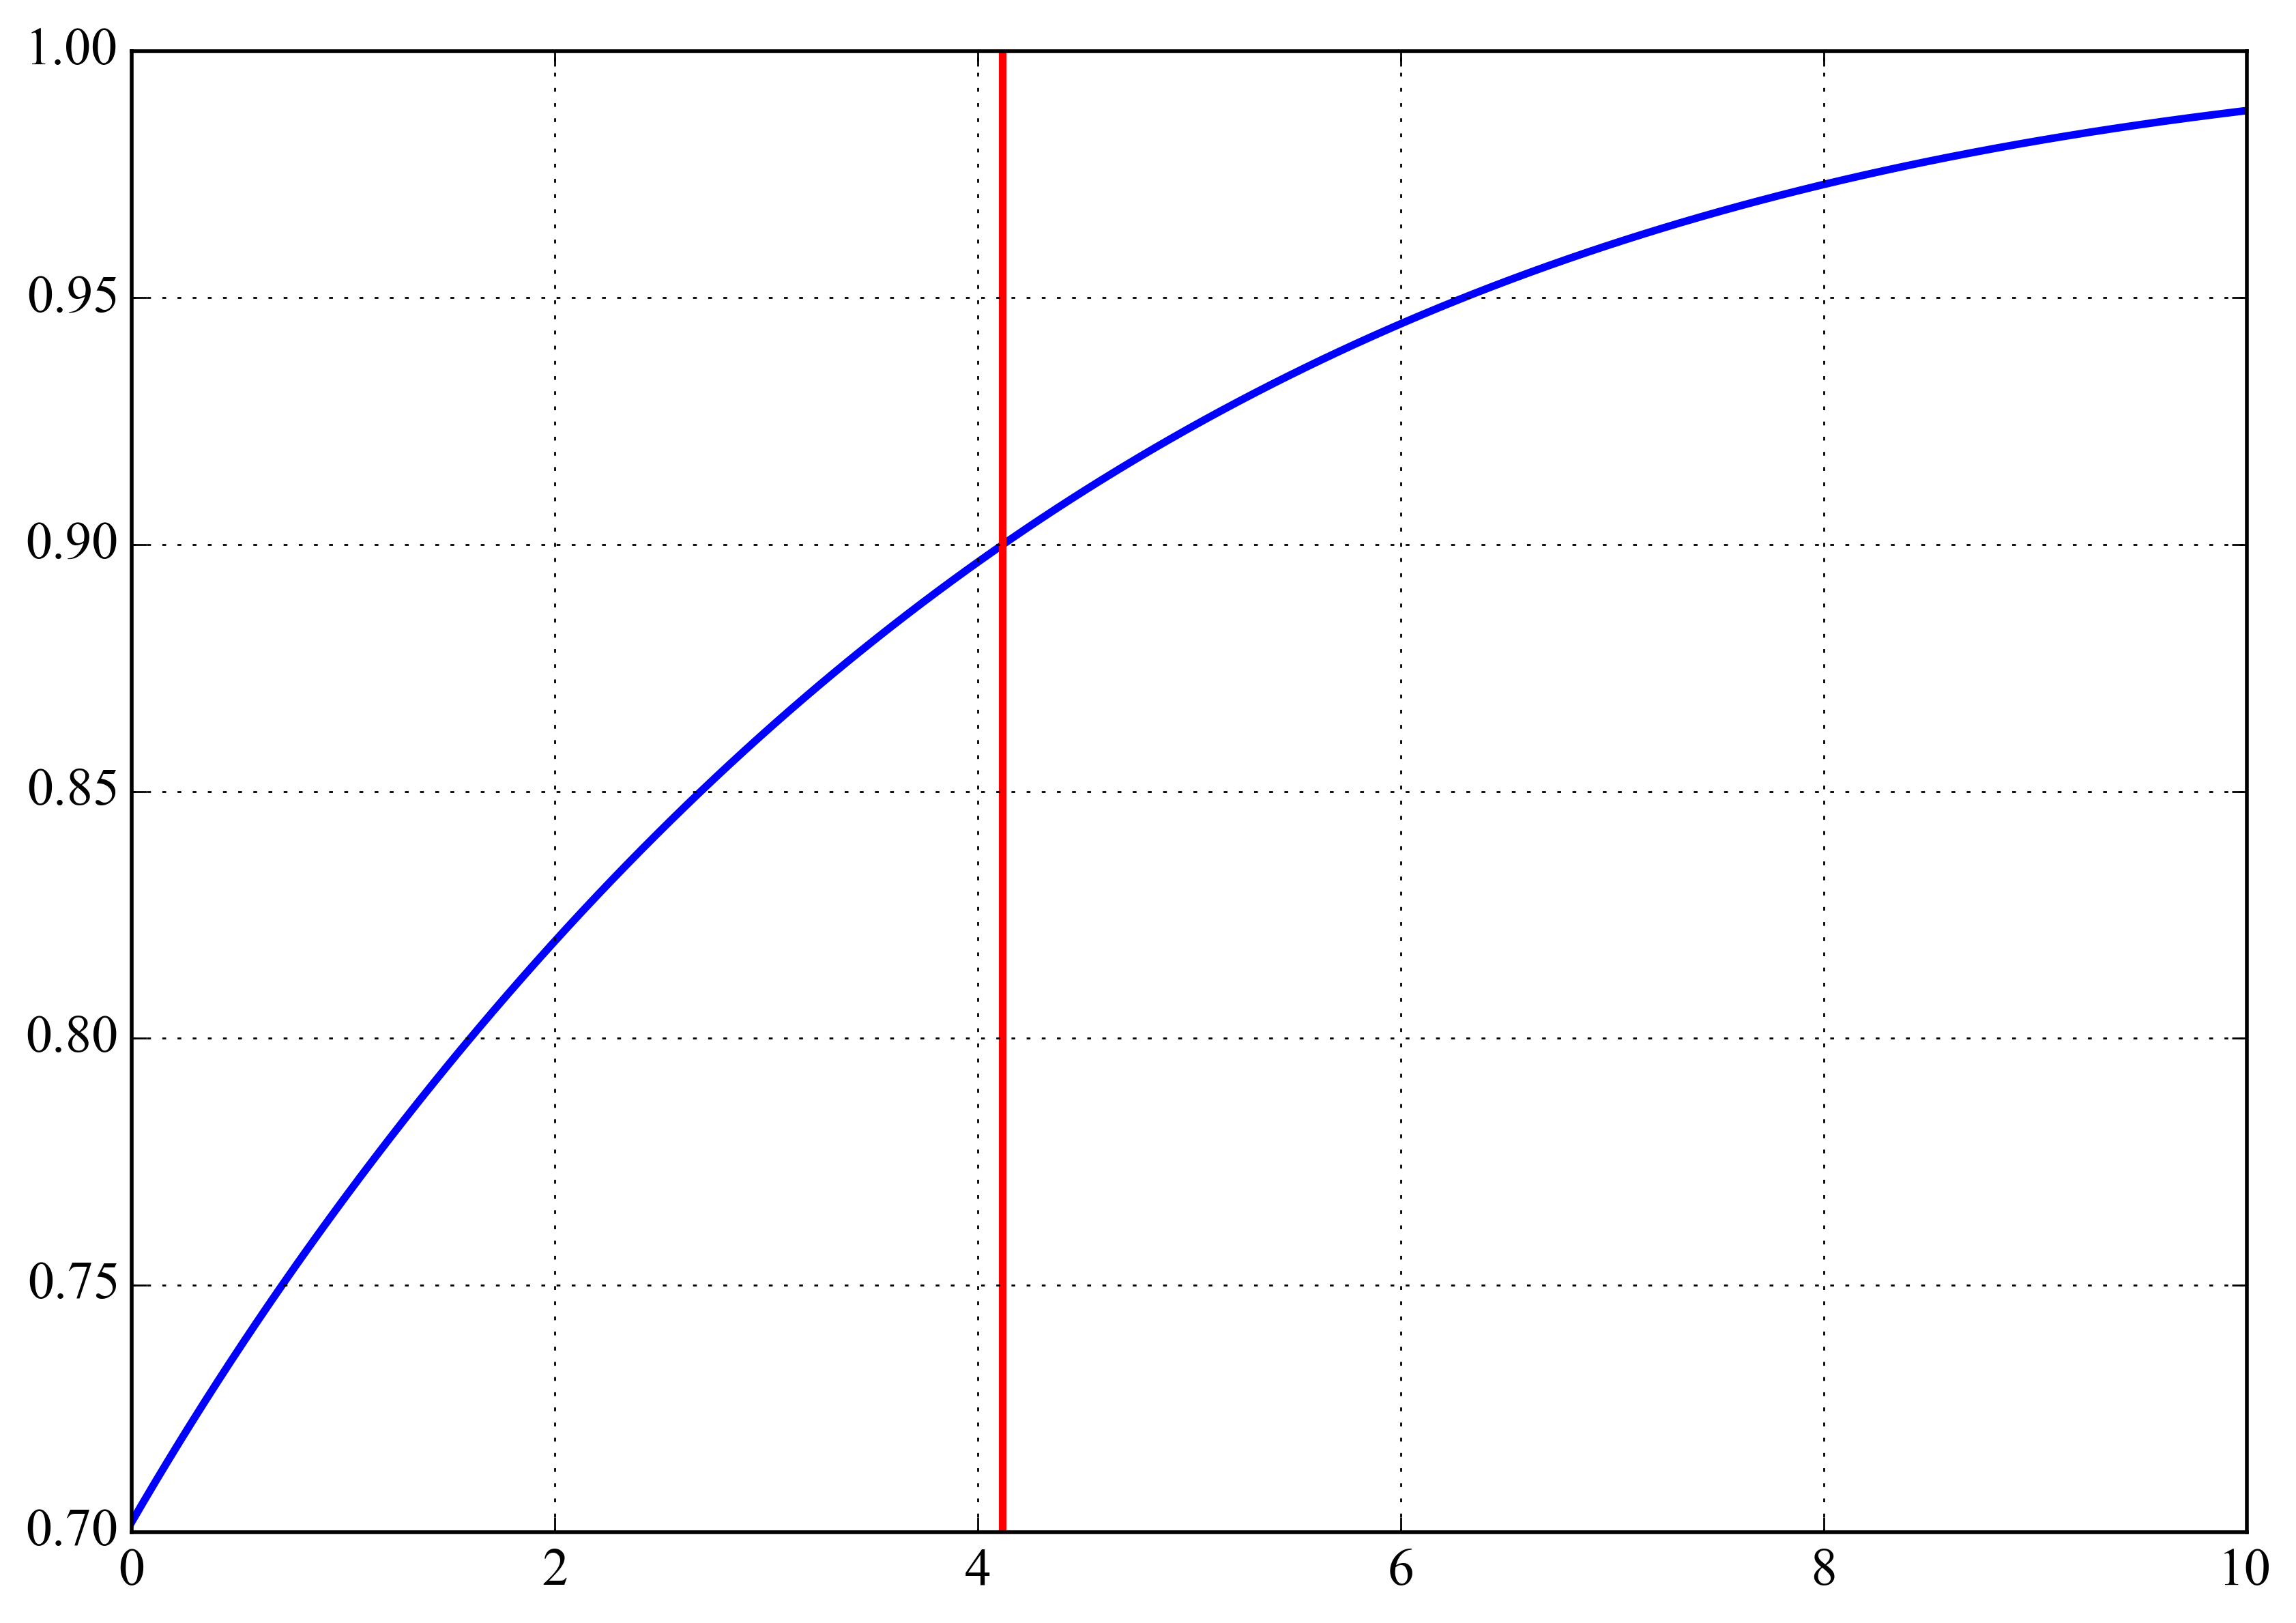

Above 0: 0.985
Above 0: 0.985


In [52]:
def DetChance(mu, DetChance=np.zeros(100)):
    """Calculates chance of detection?
    """
    if mu==0.:
        return DetChance[0]
    else:
        #Calculates Nevents, and this to calculate the probablity of observing Nevents given mean
        #Multiplied by Detchance to give... (Expectation value or something?)
        NEvents = np.array(range(len(DetChance)))
        value = DetChance * scipy.stats.poisson.pmf(NEvents, mu)
        
        #Checks if the survival function (1 - c.d.f) is still greater than 0.5
        if scipy.stats.poisson.sf(NEvents[-1], mu)>0.5:
            print('Warning, not enough statistics')
            
        #Returns sum of Z added to the survival function 
        return np.sum(value) + scipy.stats.poisson.sf(NEvents[-1], mu)

#Calculates the alpha-th percentile of the Test statistic results, as a threshold
alpha = 50.
beta = 90.
lambda_thres = np.percentile(Results[0], alpha)

#Creates a zero-array, and fills it with the percentile of each result
DetChanceArray = np.zeros(len(Results))
for i, dump in enumerate(DetChanceArray):
    DetChanceArray[i] = 1. - scipy.stats.percentileofscore(Results[i], lambda_thres)/100.
    
#Finds the sensitivity (beta(90%) chance of detection)  
f = lambda x: DetChance(x, DetChance=DetChanceArray) - beta/100.
sens = scipy.optimize.bisect(f, 0., 100., )

#Plots sensitivity as a function of n_s
x = np.linspace(0., 10., 1000.+1)
y = np.array([DetChance(z,  DetChance=DetChanceArray) for z in x])

print sens
plt.figure(figsize=(10, 7))
plt.plot(x, y, lw=2)
plt.axvline(x=sens, lw=2, color='red')
plt.grid()
plt.show()

#Returns the fraction of events with reconstructed signal (should match?)
fraction = np.sum(n_s>0.)/float(len(n_s))
print 'Above 0:', fraction

fraction = np.sum(test_stat>0.)/float(len(test_stat))
print 'Above 0:', fraction

In [44]:
# TestStatResults = Results[0]

# mask = TestStatResults>0.
# fraction = np.sum(mask)/float(len(mask))

# bins = 1000
# H, Bins = np.histogram(TestStatResults, bins=bins)
# BinCenter = (Bins[:-1] + Bins[1:]) / 2.
# chi2 = lambda p, x: scipy.stats.chi2.pdf(x, df=p)
# fitf = lambda p: chi2(p, BinCenter[1:]) - H[1:]
# opt, res = scipy.optimize.leastsq(fitf, [1.])
# fit_res = opt

# fit_res2 = scipy.stats.chi2.fit(TestStatResults[mask], df=2., floc=0., fscale=1.)

# x = np.linspace(0., 50., 1.e5)
# y = scipy.stats.chi2.pdf(x, fit_res[0]) * fraction
# y2 = scipy.stats.chi2.sf(x, fit_res2[0]) * fraction

# plt.figure()
# plt.hist(TestStatResults, bins=bins, lw=2, histtype='step',
#          normed=True, color='black', label='BG Test Stat', cumulative=-1)
# # plt.plot(x, y, lw=2, color='red', label=r'$\chi^2$ fit, df={0:6.2f}'.format(fit_res[0]))
# plt.plot(x, y2, lw=2, color='red', label=r'$\chi^2$ fit, df={0:6.2f}'.format(fit_res[0]))
# plt.semilogy()
# plt.xlim(0., 2.e1)
# plt.ylim(1.e-5, 1.e0)
# # plt.grid()
# plt.xlabel(r"$\lambda$")
# plt.ylabel(r'Cumulative Distribution')
# plt.legend(loc='best', fancybox=True, framealpha=1.)
# # plt.savefig('plots/Chi2DistFitBGOnlySpaceOnly.pdf')
# plt.savefig('plots/Chi2DistFitBGOnly.pdf')
# plt.show()

In [45]:
# TestStatResults = Results[0]

# np.save('TestStatBGOnlySpaceOnly.npy', TestStatResults)

# from ThomasChi2 import Chi2_LeftTruncated
# TestStatResults = np.load('TestStatBGOnlySpaceOnly.npy')
# fit = Chi2_LeftTruncated(TestStatResults)
# x = np.linspace(0., 20., 1000)
# y = fit.sf(x)


# plt.figure()#(figsize=(10, 7))
# plt.hist(TestStatResults, bins=x, lw=2, histtype='step', normed=True, cumulative=-1,
#          color='black', label='BG Test Stat')
# plt.plot(x, y, lw=2, color='red', label=r'$\chi^2$ fit, df={0:6.2f}'.format(fit._f.args[0]))
# plt.semilogy()
# plt.grid()
# plt.ylim(1.e-5, 1.e0)
# plt.xlabel(r'Test Statistic $\lambda$')
# plt.ylabel(r'Cumulative Distribution')
# plt.legend(loc='best', fancybox=True, framealpha=1.)
# plt.savefig('plots/BGTestStatDist.pdf')
# plt.show()

In [46]:
# x = np.array([1., 1.5, 2., 2.5, 3., 3.5, 4.])
# y = np.array([1.24251129129, 2.30366165036, 4.01744126311, 5.46040758954,
#               6.12401898656, 6.417479949, 6.58435740046])
# y2 = np.array([1.4174582023, 2.44677040566, 4.5102894845, 7.01856612219,
#                9.42312907152, 12.0455493045, 14.3850972738])



# fig, ax1 = plt.subplots()#figsize=(10,7))
# ax1.plot(x, y, lw=2, color='black', label='Energy PDF, fitted $\gamma$')
# ax1.plot(x, y2, lw=2, color='blue', label='Energy PDF, fixed $\gamma$')
# # ax1.semilogx()
# # ax1.set_xlabel(r'$f = \frac{\sigma_\mathrm{reco}}{\sigma_\mathrm{true}}$', fontsize=18)
# ax1.set_xlabel(r'Signal spectral index $\gamma$')
# ax1.set_ylabel(r'Sensitivity $[n_\mathrm{s}]$')
# ax1.axhline(y=5.39368571947, color='red', lw=2, label='No Energy PDF')
# # ax1.grid()
# ax1.legend(loc='upper left', framealpha=1., fancybox=True)
# ax1.set_xlim(1., None)
# ax1.set_ylim(0., None)
# # ax1.grid()
# fig.tight_layout()
# plt.savefig('plots/SystematicsStudySensEnergyPlotSigma.pdf')

(1.4589656529934647, 0.17764398830524863)


1.4589656529934647

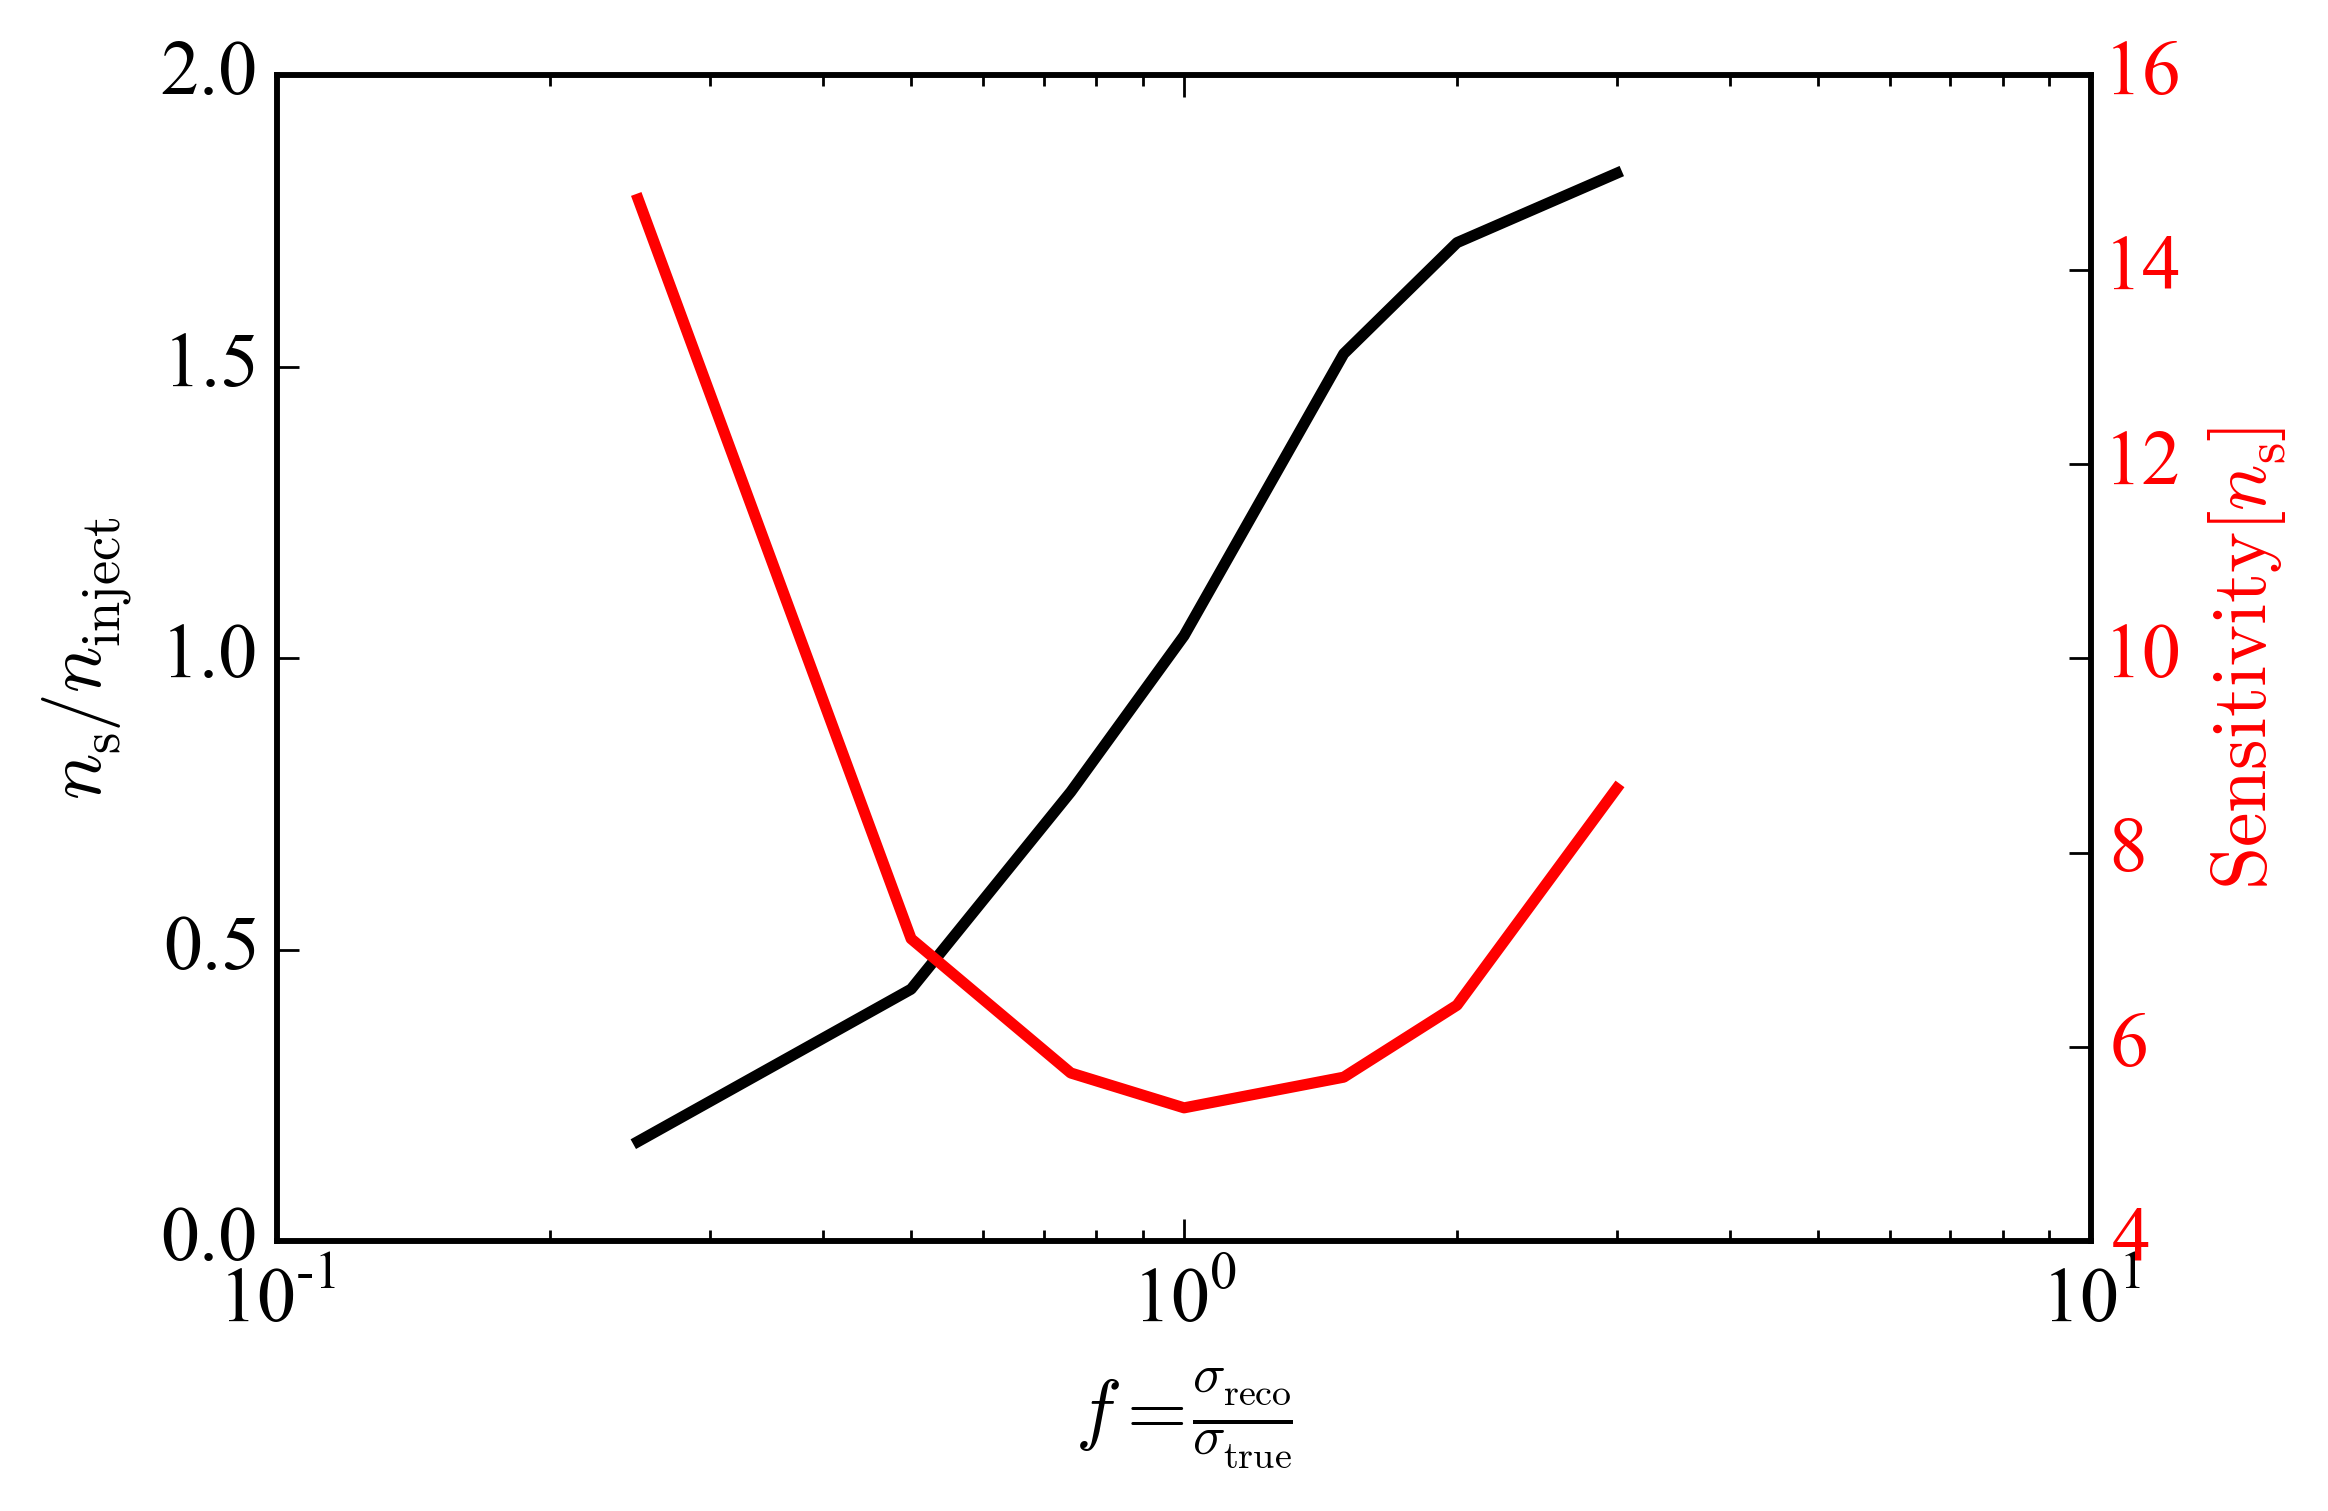

In [47]:
#Plots the Maike Effect graph (unrelated to previous code?)

x = np.array([0.25, 0.5, 0.75, 1., 1.5, 2., 3.])
y = np.array([0.171467609161, 0.432715673803, 0.771076407257, 1.03897696704,
              1.52250808664, 1.71313579543, 1.83214119779])
#y2 = np.array([0.243355263622, 0.645897943442, 1.15767646385, 1.15909212349,
#              1.04787044278, 0.750079812807, 0.277263873049]) / 1.15909212349
y3 = np.array([14.7261694818, 7.11506751484, 5.73340514068, 5.37471180272,
               5.69034329394, 6.43126388866, 8.66222026595])#/5.37471180272

fig, ax1 = plt.subplots()
ax1.plot(x, y, lw=2, color='black')
ax1.semilogx()
ax1.set_xlabel(r'$f = \frac{\sigma_\mathrm{reco}}{\sigma_\mathrm{true}}$')
ax1.set_ylabel(r'$n_\mathrm{s}/n_\mathrm{inject}$')
ax2 = ax1.twinx()
ax2.plot(x, y3, lw=2, color='red')
ax2.set_ylabel(r'$\mathrm{Sensitivity}[n_\mathrm{s}]$', color='red')
for tl in ax2.get_yticklabels():
    tl.set_color('red')
fig.tight_layout()
plt.savefig('plots/MaikeEffectWrongErrorEstimator_Robert.pdf')

x = scipy.stats.norm.rvs(loc=0, scale=1, size=2)
print scipy.stats.norm.fit(x)

np.sum(x)/2.

In [48]:
x = scipy.stats.norm.rvs(loc=0, scale=1, size=2)
print scipy.stats.norm.fit(x)

(-1.008729258171434, 0.80390811416838126)


In [49]:
np.sum(x)/2.

-1.008729258171434

In [50]:
scipy

<module 'scipy' from '/cvmfs/icecube.opensciencegrid.org/py2-v2/Ubuntu_16.04_x86_64/lib/python2.7/site-packages/scipy/__init__.pyc'>